In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from pyvbmc import VBMC
import corner
from tqdm.notebook import tqdm
import pickle
import random
from scipy.integrate import cumulative_trapezoid as cumtrapz

from time_vary_norm_utils import (
    up_or_down_RTs_fit_fn, cum_pro_and_reactive_time_vary_fn,
    rho_A_t_VEC_fn, up_or_down_RTs_fit_wrt_stim_fn, rho_A_t_fn, cum_A_t_fn)
from types import SimpleNamespace
from time_vary_and_norm_simulators import psiam_tied_data_gen_wrapper_rate_norm_fn

In [2]:
exp_df = pd.read_csv('../outExp.csv')

count = ((exp_df['RTwrtStim'].isna()) & (exp_df['abort_event'] == 3)).sum()
print("Number of rows where RTwrtStim is NaN and abort_event == 3:", count)


exp_df = exp_df[~((exp_df['RTwrtStim'].isna()) & (exp_df['abort_event'] == 3))].copy()

exp_df_batch = exp_df[
    (exp_df['batch_name'] == 'Comparable') &
    (exp_df['LED_trial'].isin([np.nan, 0]))
]

df_valid_and_aborts = exp_df_batch[
    (exp_df_batch['success'].isin([1,-1])) |
    (exp_df_batch['abort_event'] == 3)
].copy()

# 1 is right , -1 is left
df_valid_and_aborts['choice'] = df_valid_and_aborts['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))

# 1 or 0 if the choice was correct or not
df_valid_and_aborts['accuracy'] = (df_valid_and_aborts['ILD'] * df_valid_and_aborts['choice']).apply(lambda x: 1 if x > 0 else 0)

# find ABL and ILD
ABL_arr = df_valid_and_aborts['ABL'].unique()
ILD_arr = df_valid_and_aborts['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

Number of rows where RTwrtStim is NaN and abort_event == 3: 16
ABL: [10 25 40 50 55 70]
ILD: [-8.   -4.   -2.25 -1.25 -0.5   0.    0.5   1.25  2.25  4.    8.  ]


In [3]:
proactive_trunc_time = 0.3


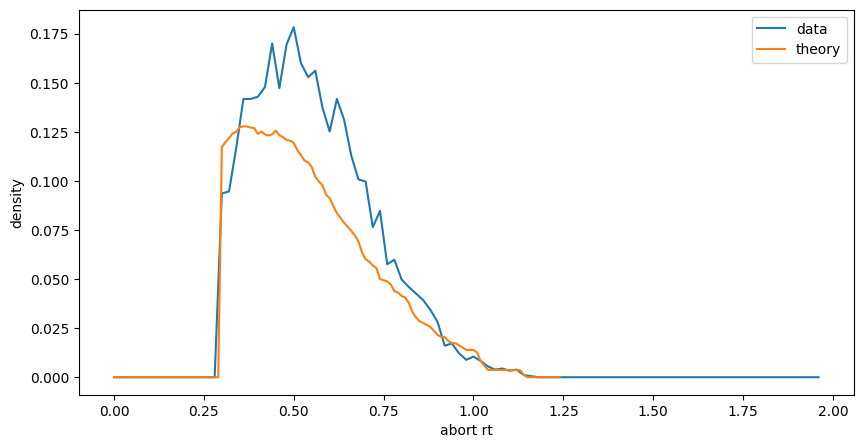

In [ ]:
df_aborts = df_valid_and_aborts[df_valid_and_aborts['abort_event'] == 3]
df_aborts_RT = df_aborts['TotalFixTime'].dropna().values
df_aborts_RT_trunc = df_aborts_RT[df_aborts_RT > proactive_trunc_time]

plt.figure(figsize=(10,5))
bins = np.arange(0,2,0.02)
frac_aborts = len(df_aborts_RT_trunc) / len(df_valid_and_aborts)
aborts_hist, _ = np.histogram(df_aborts_RT_trunc, bins=bins, density=True)
plt.plot(bins[:-1], aborts_hist * frac_aborts, label='data')
plt.xlabel('abort rt')
plt.ylabel('density')

t_pts = np.arange(0,1.25, 0.01)
V_A = 1.6; theta_A = 2.5; t_A_aff = -0.22
trunc_factor = 1 - cum_A_t_fn(proactive_trunc_time - t_A_aff, V_A, theta_A)
N_theory = int(1e3)
t_stim_samples = df_valid_and_aborts.sample(N_theory)['intended_fix']
pdf_samples = np.zeros((N_theory, len(t_pts)))
for i, t_stim in enumerate(t_stim_samples):
    t_stim_idx = np.searchsorted(t_pts, t_stim)
    proactive_trunc_idx = np.searchsorted(t_pts, proactive_trunc_time)
    pdf_samples[i, :proactive_trunc_idx] = 0
    pdf_samples[i, t_stim_idx:] = 0
    t_btn = t_pts[proactive_trunc_idx:t_stim_idx-1]
    
    pdf_samples[i, proactive_trunc_idx:t_stim_idx-1] = rho_A_t_VEC_fn(t_btn - t_A_aff, V_A, theta_A) / (1 - cum_A_t_fn(t_stim - t_A_aff, V_A, theta_A))


plt.plot(t_pts, np.mean(pdf_samples, axis=0), label='theory')
plt.legend()

0.06953796402941437

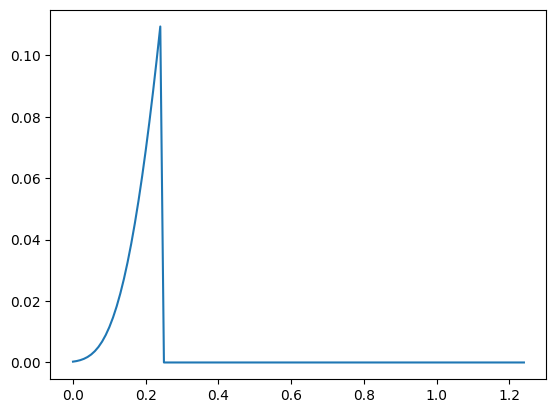

In [25]:
# from scipy.integrate import trapezoid as trapz
# trapz(np.mean(pdf_samples, axis=0), t_pts)
plt.plot(t_pts, pdf_samples[0])